In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, text


In [5]:
print(os.getcwd())
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

C:\Users\Dave\DU-DEN-GITLAB\sqlalchemy-challenge


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1589045aac8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1589049e7f0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# for row in session.query(Measurement.date, Measurement.prcp).order_by(desc(Measurement.date)).all():
#     print(row)

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date, Measurement.prcp).\
    order_by(desc(Measurement.date)).all()[0][0]

ldate = dt.strptime(last_date, '%Y-%m-%d').date()
#print(ld)
ly = ldate.year
lm = ldate.month
ld = ldate.day

fy = ly - 1
fd = dt(fy, lm, ld)

ld_str = ldate.strftime('%Y-%m-%d')
fd_str = fd.strftime('%Y-%m-%d')
print(ld_str)
print(fd_str)


2017-08-23
2016-08-23


In [13]:
# Perform a query to retrieve the date and precipitation scores-
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date < ldate).\
    filter(Measurement.date > fd)
print(last_year)

# for row in last_year:
#     print(row)

SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date < ? AND measurement.date > ?


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(last_year.statement, session.bind)
dfd = df.set_index('date')
dfd.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [15]:
# Sort the dataframe by date
dfd = dfd.dropna()
dfd = dfd.sort_index()
dfd.head(100)

,prcp
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
...,...
2016-09-10,1.16
2016-09-10,0.00
2016-09-10,0.14


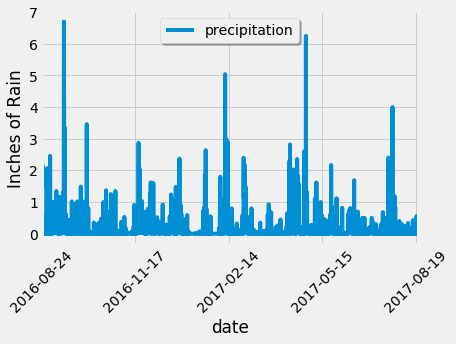

In [70]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = dfd.plot(rot='45')
L = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True)
L.get_texts()[0].set_text('precipitation')
plt.ylabel('Inches of Rain')

plt.show()
plt.close()




In [41]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(station_count)


9


In [43]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
counts = session.query(Measurement.station, func.count(Measurement.station).label('count'))\
    .group_by(Measurement.station).order_by(text('count DESC')).all()
print(counts)

most_active_station = counts[0][0]
print(most_active_station)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
USC00519281


In [44]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

stats = session.query(Measurement) \
    .filter(Measurement.station == most_active_station) \
    .with_entities(
        func.min(Measurement.tobs).label('temp_min'),
        func.max(Measurement.tobs).label('temp_max'),
        func.avg(Measurement.tobs).label('temp_avg')
    ).one()

print(round(float(stats.temp_min), 1))
print(round(float(stats.temp_max), 1))
print(round(float(stats.temp_avg), 1))


54.0
85.0
71.7


Text(0, 0.5, 'Frequency')

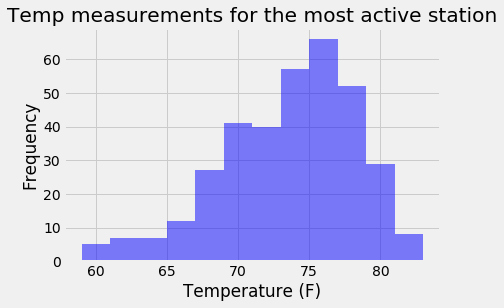

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date < ldate).\
    filter(Measurement.date > fd).all()
# print(temps)

temp_list = [x[0] for x in temps]

#print(temp_list)

num_bins = 12
# the histogram of the data
n, bins, patches = plt.hist(temp_list, num_bins, facecolor='blue', alpha=0.5)
plt.title('Temp measurements for the most active station')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')



In [46]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [47]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_fd_str = '2017-07-10'
my_ld_str = '2017-07-15'
temps = calc_temps(my_fd_str, my_ld_str)
print(temps)



[(69.0, 78.325, 82.0)]


69.0, 78.325, 82.0


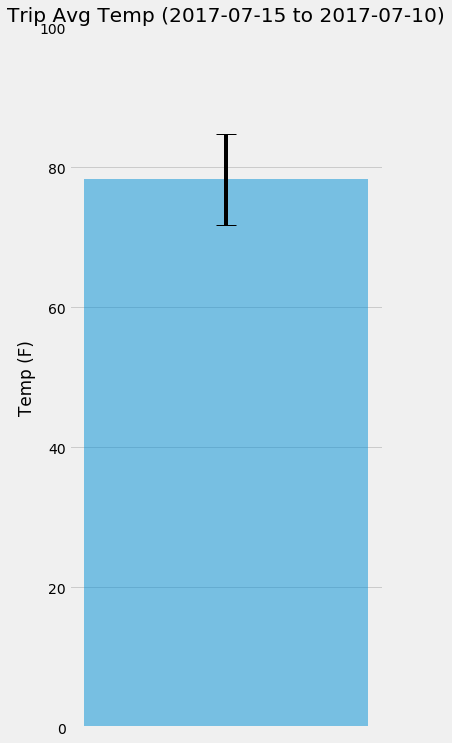

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min = temps[0][0]
avg = temps[0][1]
max = temps[0][2]
print(f'{min}, {avg}, {max}')

# Build the plot
fig, ax = plt.subplots(figsize=(5,12))
ax.bar([1], avg, yerr=[(max-min)/2], align='center', alpha=0.5, ecolor='black', capsize=10, width = 0.2)
ax.set_ylabel('Temp (F)')
ax.set_xticks([0])
ax.set_title('Trip Avg Temp (2017-07-15 to 2017-07-10)')
ax.yaxis.grid(True)

plt.ylim(0, 100)
plt.show()


In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# # Get the stations and prcp in the time frame
# print(my_fd_str)
# print(my_ld_str)
results = session.query(Measurement.station, Measurement.prcp).\
        filter(Measurement.date >= fd_str).filter(Measurement.date <= ld_str).all()
# for result in results:
#     print(result)

# group by stations and sum the precipitation
rdf = pd.DataFrame(results)
rdf.head()
rdfs = rdf.groupby('station')['prcp'].sum()
# rdfg.head()

# sort by precipitation
rdfs = rdfs.sort_values(ascending=False)
#print(rdfg.index[0])
rdfs.head()
# make it back into a DataFrame
rdf_df = rdfs.to_frame().reset_index()
rdf_df.head()

# Get the station name, latitude, longitude, and elevation
# Get a dataframe of the stations data
stations = session.query(Station.station,\
                         Station.name,\
                         Station.latitude,\
                         Station.longitude,\
                         Station.elevation
                        )
st_df = pd.DataFrame(stations)
st_df.head()

# Merge the station df and the results df, basically a join
mdf = rdf_df.merge(right=st_df, how='left', on='station')
mdf.head(100)



,station,prcp,name,latitude,longitude,elevation
0,USC00516128,147.81,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,70.03,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,48.51,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,38.01,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,33.24,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,16.09,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,4.59,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [50]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
# daily_normals("01-01")

In [51]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(my_fd_str)
print(my_ld_str)

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


2017-07-10
2017-07-15


In [52]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [53]:
# Plot the daily normals as an area plot with `stacked=False`
